In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jackylim1476","key":"5c689c2544a82571337cf3e891346bc2"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d andrewmvd/medical-mnist

 72% 61.0M/84.8M [00:00<00:00, 71.3MB/s]
100% 84.8M/84.8M [00:00<00:00, 103MB/s] 


In [5]:
import os
os.makedirs("/content/dataset")

In [6]:
!unzip -qq /content/medical-mnist.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/HeadCT/005000.jpeg  
  inflating: /content/dataset/HeadCT/005001.jpeg  
  inflating: /content/dataset/HeadCT/005002.jpeg  
  inflating: /content/dataset/HeadCT/005003.jpeg  
  inflating: /content/dataset/HeadCT/005004.jpeg  
  inflating: /content/dataset/HeadCT/005005.jpeg  
  inflating: /content/dataset/HeadCT/005006.jpeg  
  inflating: /content/dataset/HeadCT/005007.jpeg  
  inflating: /content/dataset/HeadCT/005008.jpeg  
  inflating: /content/dataset/HeadCT/005009.jpeg  
  inflating: /content/dataset/HeadCT/005010.jpeg  
  inflating: /content/dataset/HeadCT/005011.jpeg  
  inflating: /content/dataset/HeadCT/005012.jpeg  
  inflating: /content/dataset/HeadCT/005013.jpeg  
  inflating: /content/dataset/HeadCT/005014.jpeg  
  inflating: /content/dataset/HeadCT/005015.jpeg  
  inflating: /content/dataset/HeadCT/005016.jpeg  
  inflating: /content/dataset/HeadCT/005017.jpeg  
  inflating: /content/dataset/H

In [7]:
os.makedirs("/content/test_dataset")

In [8]:
import shutil, pathlib  # shutil is for transferring data file, while pathlib is for file path definition
import numpy as np

new_test_dir = pathlib.Path() / "test_dataset"
ori_data_dir = pathlib.Path() / "dataset"
categories = ["AbdomenCT", "BreastMRI", "CXR", "ChestCT", "Hand", "HeadCT"]

for category in categories:
  dir = new_test_dir / category
  os.makedirs(dir)
  ori_dir = ori_data_dir / category
  num_files = len(os.listdir(ori_dir))
  rand_idx = np.random.permutation(num_files)
  files = os.listdir(ori_dir)[:200]

  for file in files:
    shutil.copyfile(src=ori_dir / file,
                    dst=dir / file)
    os.remove(ori_dir / file)

In [9]:
# check the working directory
pathlib.Path().absolute()

PosixPath('/content')

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    ori_data_dir,
    validation_split=0.2,
    subset="training",
    seed = 100,
    color_mode = "grayscale",
    image_size = (64, 64),
    batch_size = 128
)

val_dataset = image_dataset_from_directory(
    ori_data_dir,
    validation_split=0.2,
    subset="validation",
    seed = 100,
    color_mode = "grayscale",
    image_size = (64, 64),
    batch_size = 128
)

test_dataset = image_dataset_from_directory(
    new_test_dir,
    color_mode = "grayscale",
    image_size=(64, 64),
    batch_size = 128
)

Found 57754 files belonging to 6 classes.
Using 46204 files for training.
Found 57754 files belonging to 6 classes.
Using 11550 files for validation.
Found 1200 files belonging to 6 classes.


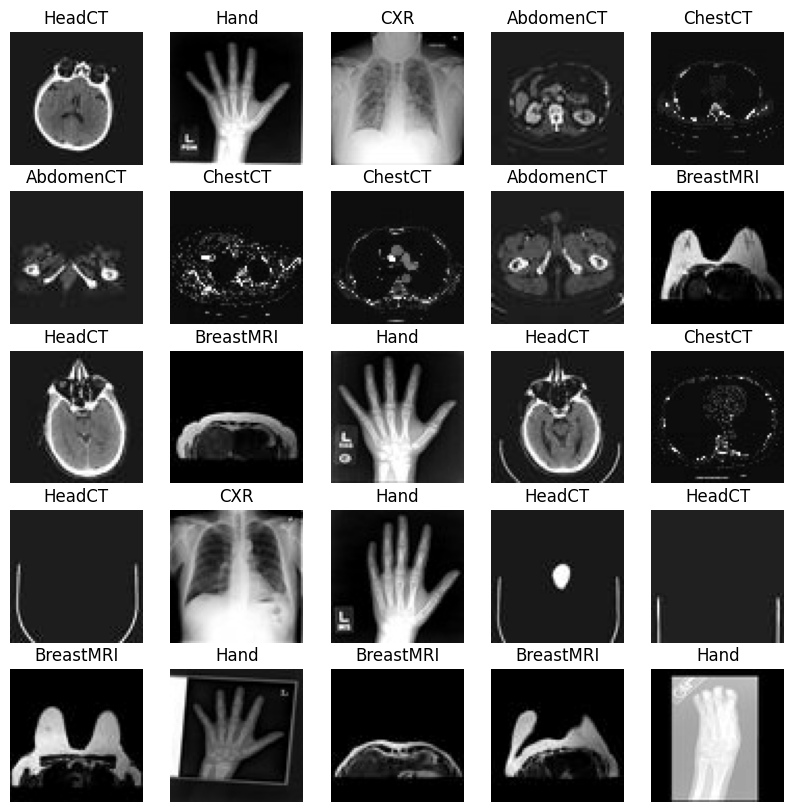

In [11]:
import matplotlib.pyplot as plt
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(2):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.gray)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
# check the image dimension
images[0].numpy().shape

(64, 64, 1)

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

# follow the input image shape above
inputs = keras.Input(shape=(64, 64, 1))

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                         

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="basic_convnet.h5",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/30
361/361 [==============================] - 31s 44ms/step - loss: 0.0794 - accuracy: 0.9771 - val_loss: 0.0142 - val_accuracy: 0.9973
Epoch 2/30
361/361 [==============================] - 10s 27ms/step - loss: 0.0098 - accuracy: 0.9976 - val_loss: 0.0070 - val_accuracy: 0.9985
Epoch 3/30
361/361 [==============================] - 9s 25ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0044 - val_accuracy: 0.9988
Epoch 4/30
361/361 [==============================] - 10s 26ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.0044 - val_accuracy: 0.9994
Epoch 5/30
361/361 [==============================] - 10s 27ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0036 - val_accuracy: 0.9992
Epoch 6/30
361/361 [==============================] - 10s 27ms/step - loss: 0.0314 - accuracy: 0.9932 - val_loss: 0.0063 - val_accuracy: 0.9989
Epoch 7/30
361/361 [==============================] - 9s 25ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0052 - val_accuracy: 0

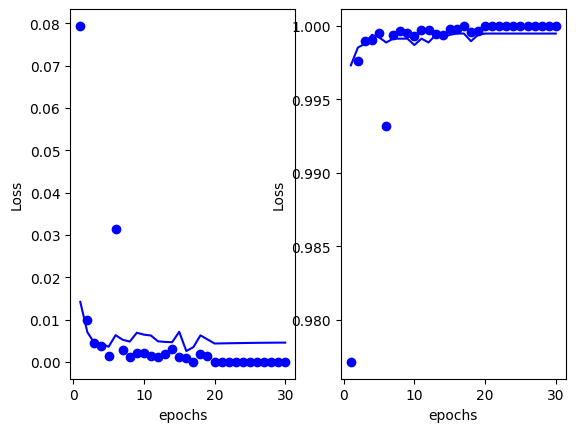

In [16]:
# train loss, val loss, train acc, val acc
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, len(train_loss)+1)
plt.figure()
plt.subplot(121), plt.plot(epochs, train_loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.xlabel("epochs"), plt.ylabel("Loss")
plt.subplot(122), plt.plot(epochs, train_acc, "bo", label="training accuracy")
plt.plot(epochs, val_acc, "b", label="validation loss")
plt.xlabel("epochs"), plt.ylabel("Loss")
plt.show()

In [17]:
inputs = keras.Input(shape=(64, 64, 1))

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                       

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4),
    keras.callbacks.ModelCheckpoint(
        filepath="basic_convnet.h5",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/30
361/361 [==============================] - 13s 29ms/step - loss: 0.0906 - accuracy: 0.9713 - val_loss: 0.0131 - val_accuracy: 0.9978
Epoch 2/30
361/361 [==============================] - 11s 30ms/step - loss: 0.0105 - accuracy: 0.9976 - val_loss: 0.0058 - val_accuracy: 0.9990
Epoch 3/30
361/361 [==============================] - 14s 38ms/step - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.0061 - val_accuracy: 0.9989
Epoch 4/30
361/361 [==============================] - 10s 27ms/step - loss: 0.0049 - accuracy: 0.9988 - val_loss: 0.0031 - val_accuracy: 0.9993
Epoch 5/30
361/361 [==============================] - 12s 33ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0046 - val_accuracy: 0.9992
Epoch 6/30
361/361 [==============================] - 10s 28ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0042 - val_accuracy: 0.9991
Epoch 7/30
361/361 [==============================] - 10s 26ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0258 - val_accuracy:

In [19]:
#Test the model
test_model = keras.models.load_model("basic_convnet.h5")
scores = test_model.evaluate(test_dataset)

print("Test loss: ", scores[0])
print("Test accuracy: ", 100 * round(scores[1], 4), "%")

10/10 [==============================] - 1s 37ms/step - loss: 4.8073e-04 - accuracy: 1.0000
Test loss:  0.0004807314835488796
Test accuracy:  100.0 %


In [20]:
from google.colab import files
# import os
import requests

img_data = requests.get("https://www.healthpages.org/wp-content/uploads/hand-x-ray.jpg").content
with open('hand_x_ray.jpg', 'wb') as handler:
    handler.write(img_data)

# files.download('hand_x_ray.jpg')
# os.remove('hand_x_ray.jpg')

In [21]:
import cv2 as cv

img_test = cv.imread("/content/hand_x_ray.jpg", 0)
img_test_resize = cv.resize(img_test, (64, 64))

In [22]:
img_test_resize.shape

(64, 64)

In [23]:
img_test_resize = img_test_resize.reshape((64, 64, 1))
img_test_resize = np.expand_dims(img_test_resize, 0)

In [24]:
img_test_resize.shape

(1, 64, 64, 1)

In [25]:
pred = test_model.predict(img_test_resize)

1/1 [==============================] - 0s 379ms/step


In [26]:
pred

array([[3.2548632e-12, 2.5781029e-07, 3.2066350e-07, 4.1247704e-16,
        9.9996531e-01, 3.4082244e-05]], dtype=float32)

In [28]:
print(f"The most likely class: {class_names[np.argmax(pred)]} with probability of {pred.max():.2f}.")

The most likely class: Hand with probability of 1.00.
